# Lifetime emissions from aircraft 
Based on https://theicct.org/publication/lifetime-emissions-from-aircraft-under-a-net-zero-carbon-budget-jul24/


## Tank-to-wake emissions

Reproduce

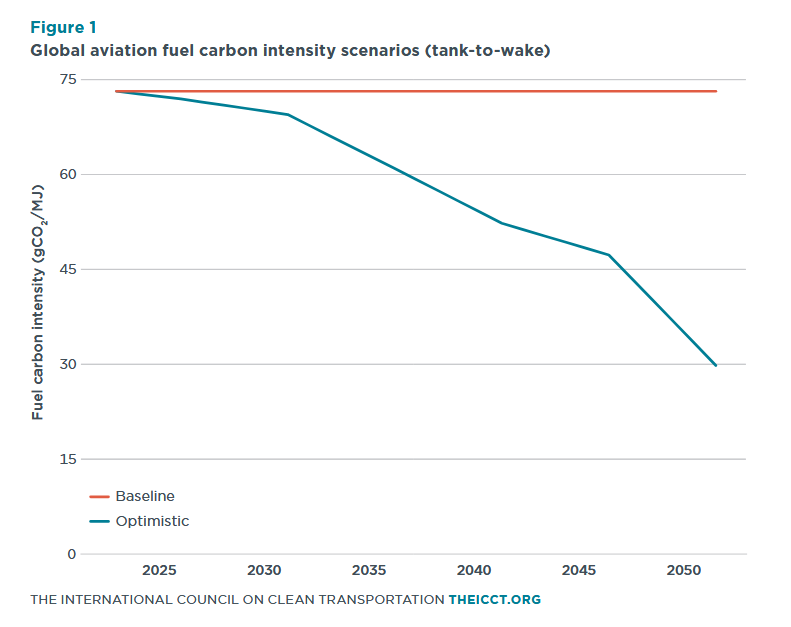

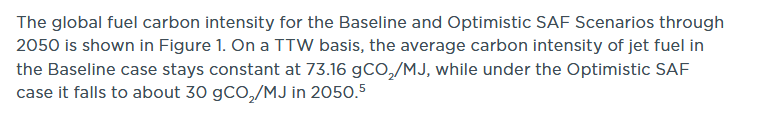

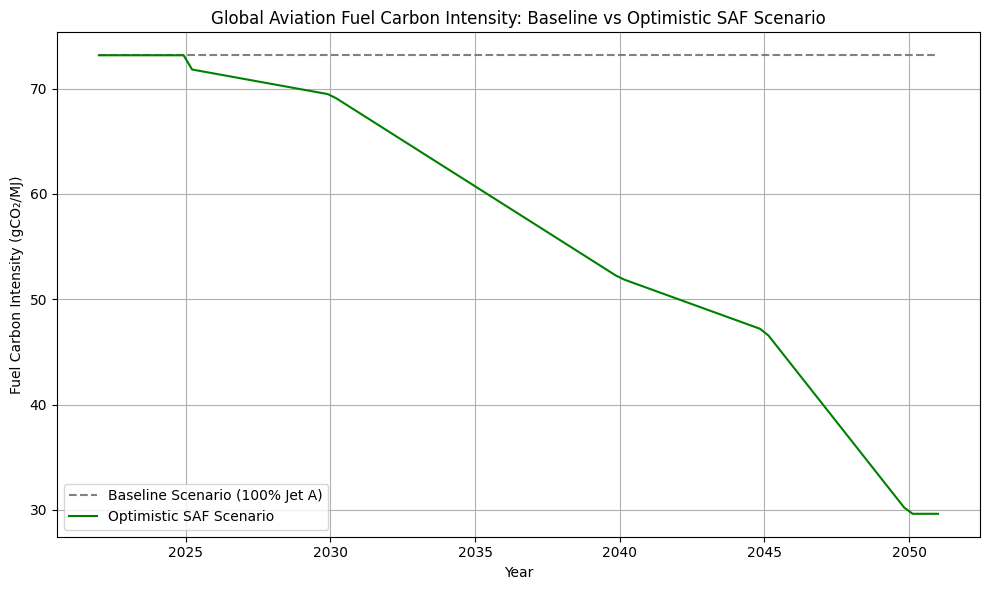

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Model Parameters
# =============================================================================

# Fuel parameters
FUEL_SPECIFIC_ENERGY = 42.8  # MJ per kg of fuel
BASELINE_CI          = 73.16/1e3                 # kgCO2/MJ for 100% Jet A baseline
TARGET_CI            = BASELINE_CI * 0.15        # kgCO2/MJ for 100% SAF


# =============================================================================
# Step functions as in legislation
# =============================================================================

#refuel_years    = np.arange(2025, 2051)
#biofuel_share   = np.array([2, 2, 2, 2, 2, 4.8, 4.8, 4.0, 4.0, 4.0,
#                          15.0, 15.0, 15.0, 15.0, 15.0, 24.0, 24.0,
#                          24.0, 24.0, 24.0, 27.0, 27.0, 27.0, 27.0,
#                          27.0, 35.0]) / 100  # Convert to fraction
#
#ekerosene_share = np.array([0, 0, 0, 0, 0, 1.2, 1.2, 2.0,
#                            2.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 10.0,
#                            10.0, 10.0, 10.0, 10.0, 15.0, 15.0, 15., 15., 15., 35.0]) / 100  # Convert to fraction


# =============================================================================
# Linear interpolation as in ICCT publication, ignore that mandated volume in 2032 is still explicitly 6%
# =============================================================================
refuel_years    = np.array([2024, 2025, 2030, 2035, 2040, 2045, 2050])
biofuel_share   = np.array([ 0.0, 2.0,  4.8,  15.0, 24.0, 27.0, 35.0]) / 100  # Convert to fraction
ekerosene_share = np.array([ 0.0, 0.0,  1.2,  5.0, 10.0, 15.0, 35.0]) / 100  # Convert to fraction


saf_share = biofuel_share + ekerosene_share

# Compute effective CI for both scenarios
baseline_ci   = np.full_like(refuel_years, BASELINE_CI)
optimistic_ci = BASELINE_CI * (1 - saf_share) + TARGET_CI * saf_share


def effective_fuel_ci_baseline(year):
    """
    Returns constant carbon intensity for Jet A (no SAF).
    """
    return BASELINE_CI

def effective_fuel_ci_optimistic(year):
    """
    Returns SAF-adjusted carbon intensity between 2025 and 2050.
    Linearly interpolates between years.
    """
    if year < 2025:
        return BASELINE_CI
    elif year > 2050:
        return np.interp(2050, refuel_years, optimistic_ci)
    else:
        return np.interp(year, refuel_years, optimistic_ci)


# SAF shares according to ReFuelEU (biofuel + e-kerosene)
years = np.linspace(2022, 2051, 100)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, [1000 * effective_fuel_ci_baseline(year) for year in years], label='Baseline Scenario (100% Jet A)', linestyle='--', color='grey')
plt.plot(years, [1000 * effective_fuel_ci_optimistic(year) for year in years], label='Optimistic SAF Scenario', color='green')
plt.xlabel('Year')
plt.ylabel('Fuel Carbon Intensity (gCO₂/MJ)')
plt.title('Global Aviation Fuel Carbon Intensity: Baseline vs Optimistic SAF Scenario')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Survival rates

Reproduce by trial-and-error since the original publication is not public
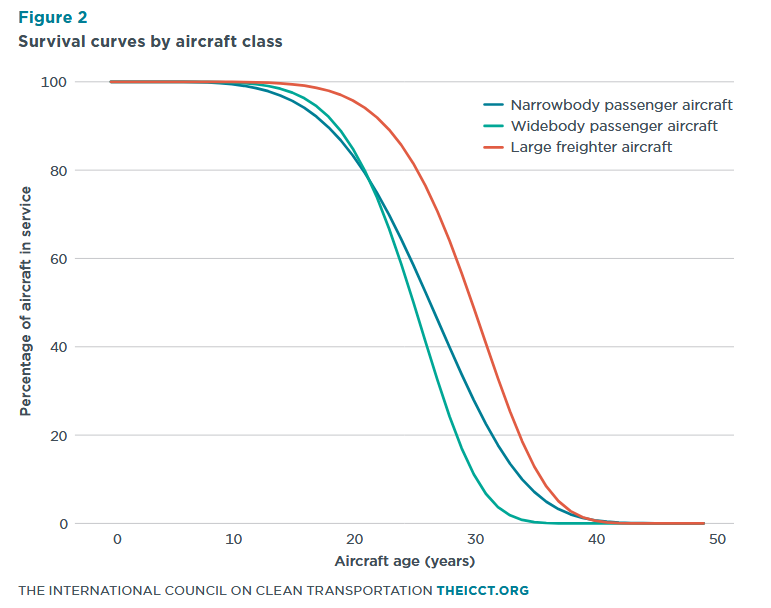

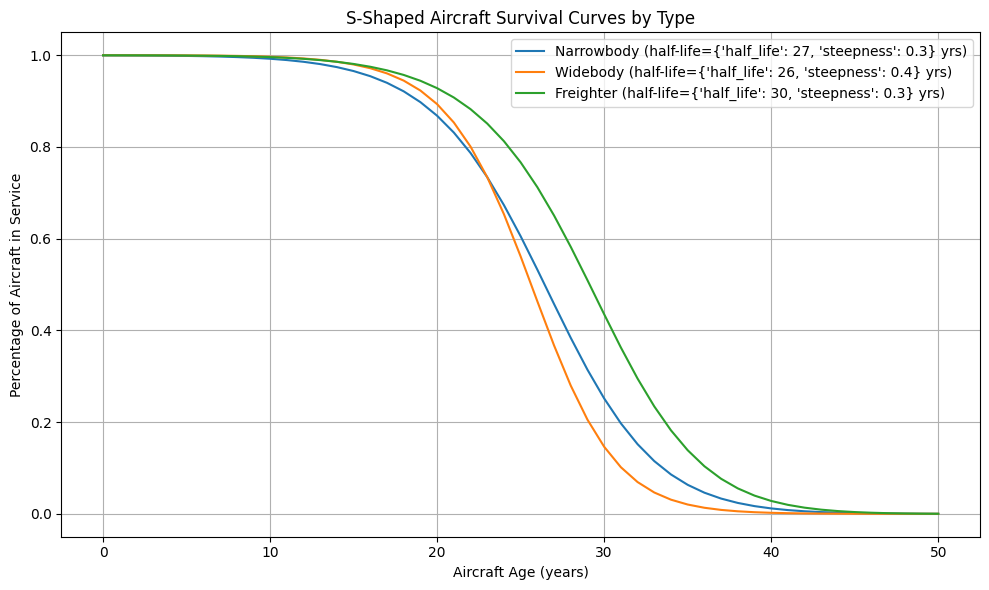

In [9]:
from scipy.special import expit

# Define aircraft-specific half-life parameters
half_lives_and_steepness = {
    'Narrowbody': {"half_life": 27, "steepness": 0.3},
    'Widebody': {"half_life": 26, "steepness": 0.4},
    'Freighter': {"half_life": 30, "steepness": 0.3},
}

# Define age range
ages = np.arange(0, 51)

# Define a modified survival rate function with S-shaped curve
def s_shaped_survival_rate(age, half_life, steepness=0.3, max_age=50):
    """
    S-shaped survival curve: 100% survival until about half_life,
    then drops and converges smoothly to zero at max_age.
    """
    # Scale the logistic function to drop around half_life
    return expit(-(age - half_life) * steepness) * (1 - (age / max_age) ** 4)

def survival_rate(age, aircraft_type):
    return s_shaped_survival_rate(age, **half_lives_and_steepness[aircraft_type])
# Generate survival curves with S-shape
s_shaped_survival_curves = {
    atype: survival_rate(ages, atype) for atype, params in half_lives_and_steepness.items()
}

# Plotting
plt.figure(figsize=(10, 6))
for atype, survival in s_shaped_survival_curves.items():
    plt.plot(ages, survival, label=f'{atype} (half-life={half_lives_and_steepness[atype]} yrs)')

plt.xlabel('Aircraft Age (years)')
plt.ylabel('Percentage of Aircraft in Service')
plt.title('S-Shaped Aircraft Survival Curves by Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Activity hours

Reproduce by trial-and-error since the original publication is not public

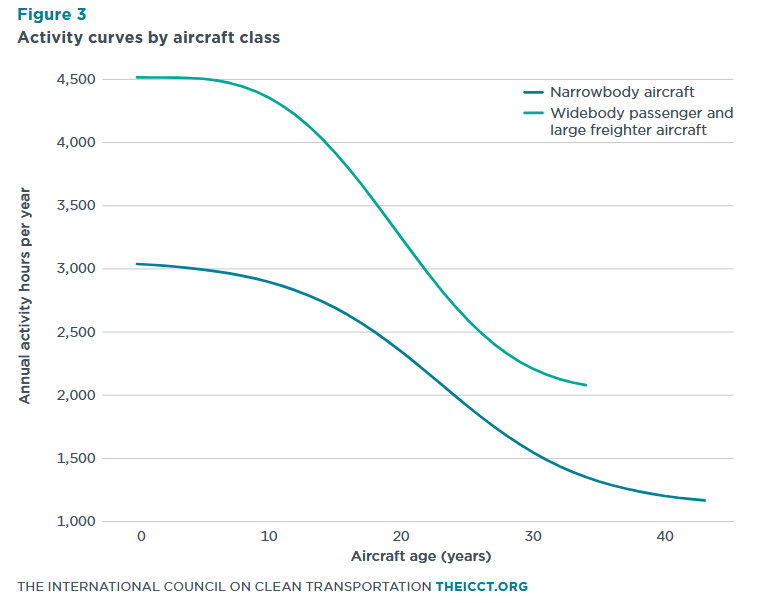

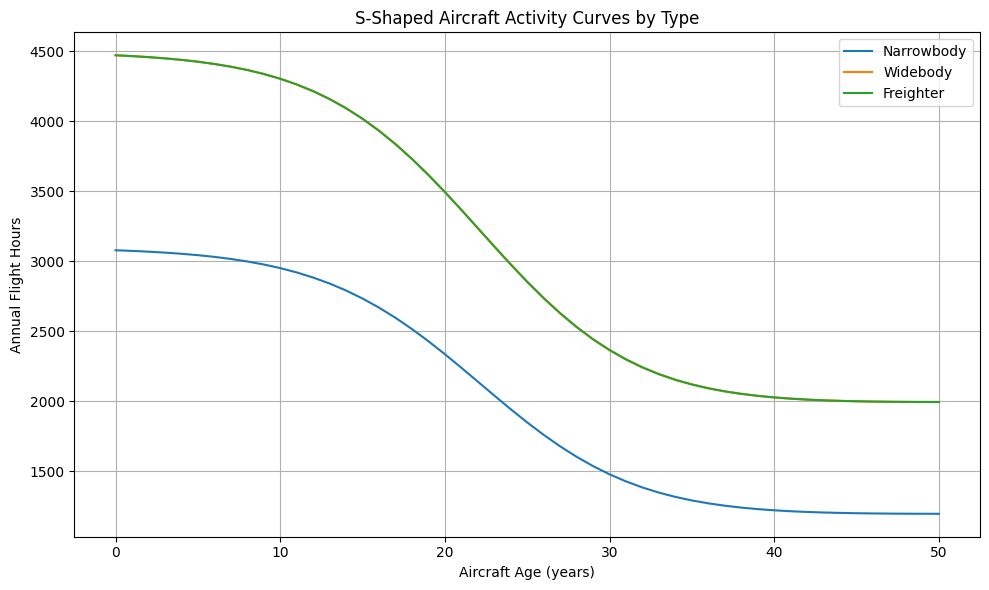

In [10]:
# Define aircraft-specific activity parameters
activity_profiles = {
    'Narrowbody': {'start_hours': 3100, 'end_hours': 1200, 'end_age': 45},
    'Widebody': {'start_hours': 4500, 'end_hours': 2000, 'end_age': 45},
    'Freighter': {'start_hours': 4500, 'end_hours': 2000, 'end_age': 45},
}

# Define S-curve activity function
def s_shaped_activity_hours(age, start_hours, end_hours, end_age, steepness=0.2):
    """
    Generate an S-curve decline in annual flight hours with aircraft age.
    """
    midpoint = end_age / 2
    logistic_drop = expit(-(age - midpoint) * steepness)
    normalized_curve = logistic_drop * (1 - (age / end_age) ** 4)
    return end_hours + (start_hours - end_hours) * normalized_curve

def activity_hours(age, aircraft_type):
    return s_shaped_activity_hours(age, **activity_profiles[aircraft_type])

# Compute activity curves
activity_curves = {
    atype: activity_hours(ages, atype)
    for atype, params in activity_profiles.items()
}

# Plotting
plt.figure(figsize=(10, 6))
for atype, activity in activity_curves.items():
    plt.plot(ages, activity, label=f'{atype}')

plt.xlabel('Aircraft Age (years)')
plt.ylabel('Annual Flight Hours')
plt.title('S-Shaped Aircraft Activity Curves by Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# =============================================================================
# Function Definitions
# =============================================================================

def compute_emission_rate(mission_speed, fuel_burn, fuel_specific_energy, fuel_carbon_intensity):
    """
    Compute the aircraft CO₂ emissions rate (kg CO₂ per hour) using Equation (1) from the paper.

    Parameters:
      mission_speed: Speed (km/h)
      fuel_burn: Fuel burn per km (kg/km)
      fuel_specific_energy: Energy per unit mass of fuel (MJ/kg)
      fuel_carbon_intensity: TTW fuel carbon intensity (kg CO₂/MJ)

    Returns:
      Emissions rate in kg CO₂ per hour.
    """
    return mission_speed * fuel_burn * fuel_specific_energy * fuel_carbon_intensity

def lifetime_emissions(aircraft, fuel_specific_energy, fuel_ci_function, start_year, lifespan):
    """
    Calculate the lifetime emissions (kg CO₂) for a given emissions rate by summing
    across each operational year (0 to lifespan) weighted by activity and survival.

    Parameters:
      aircraft: string for aircraft type
      fuel_specific_energy: fuel volume
      fuel_ci_function: function that returns the CI of the fuel mix as a function of the year
      start_year: determines start year of the fuel mix
      lifespan: Number of years over which the aircraft is assumed to operate.

    Returns:
      Total lifetime CO₂ emissions (kg).
    """
    emissions = 0.0
    age = int(aircraft.age)
    # Using a smaller time step for a higher integration resolution and not rounding the age would be more accurate
    # However, results differ from ICCT study a little more in that case
    # I assume the ICCT study used integer steps for the integration
    step = 1.0

    while age < lifespan:
        year       = start_year + age
        hours      = activity_hours(age, aircraft.aircraft_type)
        surv       = survival_rate(age, aircraft.aircraft_type)
        fuel_ci    = fuel_ci_function(year)
        rate       = aircraft.emission_rate(fuel_specific_energy, fuel_ci)
        emissions += hours * surv * rate * step  # scale by time step
        age       += step

    return aircraft.count * emissions


# =============================================================================
# Aircraft Class Definition
# =============================================================================


class Aircraft:
    def __init__(self, name, aircraft_type, mission_speed, fuel_burn, count=1, age=0):
        self.name = name
        self.aircraft_type = aircraft_type  # e.g. 'Narrowbody'
        self.mission_speed = mission_speed
        self.fuel_burn = fuel_burn
        self.count = count
        self.age = age # Start age for the existing fleet

    def emission_rate(self, fuel_specific_energy, fuel_carbon_intensity):
        return compute_emission_rate(self.mission_speed, self.fuel_burn, fuel_specific_energy, fuel_carbon_intensity)

# Emissions of the existing fleet


## 2023 fleet in terms of representative aircraft types

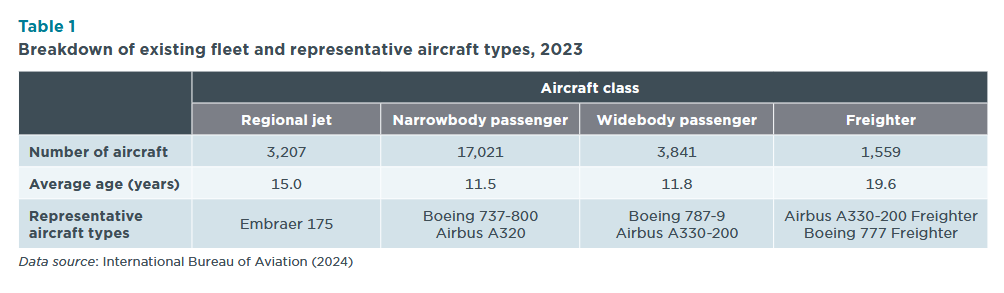
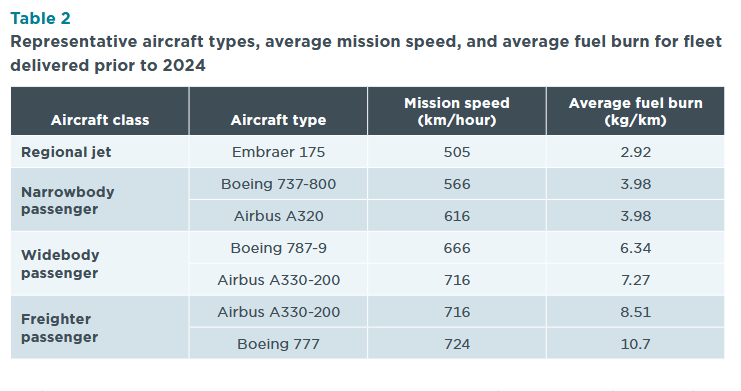

In [ ]:


print("Lifetime Emissions for the Existing Fleet (Baseline Scenario):")

# Assume equal splits between Boeing and Airbus narrowbody, widebody and freighter
existing_fleet = [
    Aircraft('Embraer 175', 'Narrowbody', mission_speed=505, fuel_burn=2.92, count=3207, age=15),
    Aircraft('Boeing 737-800', 'Narrowbody', mission_speed=566, fuel_burn=3.98, count=int(17021/2), age=11.5),
    Aircraft('Airbus A320', 'Narrowbody', mission_speed=616, fuel_burn=3.98, count=int(17021/2), age=11.5),
    Aircraft('Boeing 787-9', 'Widebody', mission_speed=666, fuel_burn=6.34, count=int(3841/2), age=11.8),
    Aircraft('Airbus A330-200', 'Widebody', mission_speed=716, fuel_burn=7.27, count=int(3841/2), age=11.8),
    Aircraft('Boeing 777 Freighter', 'Freighter', mission_speed=724, fuel_burn=10.7, count=int(1559/2), age=19.6),
    Aircraft('Airbus A330-200 Freighter', 'Freighter', mission_speed=716, fuel_burn=8.51, count=int(1559/2), age=19.6)
]

total_emissions_existing = 0.0
type_emission_existing = {}
for ac in existing_fleet:
    le = lifetime_emissions(
        ac,
        fuel_specific_energy=FUEL_SPECIFIC_ENERGY,
        fuel_ci_function=effective_fuel_ci_baseline,  # use baseline scenario
        start_year=2023,
        lifespan=50
    )
    print(f"  {ac.name}: {le / 1e12:.2f} Gt CO₂")
    total_emissions_existing += le
    type_emission_existing[ac.name] = le

print(f"Total Existing Fleet Emissions: {total_emissions_existing / 1e12:.1f} Gt CO₂ vs 9.1 Gt CO₂ according to the study \n")


Lifetime Emissions for the Existing Fleet (Baseline Scenario):
  Embraer 175: 0.38 Gt CO₂
  Boeing 737-800: 2.23 Gt CO₂
  Airbus A320: 2.42 Gt CO₂
  Boeing 787-9: 1.37 Gt CO₂
  Airbus A330-200: 1.68 Gt CO₂
  Boeing 777 Freighter: 0.58 Gt CO₂
  Airbus A330-200 Freighter: 0.46 Gt CO₂
Total Existing Fleet Emissions: 9.1 Gt CO₂ vs 9.1 Gt CO₂ according to the study 



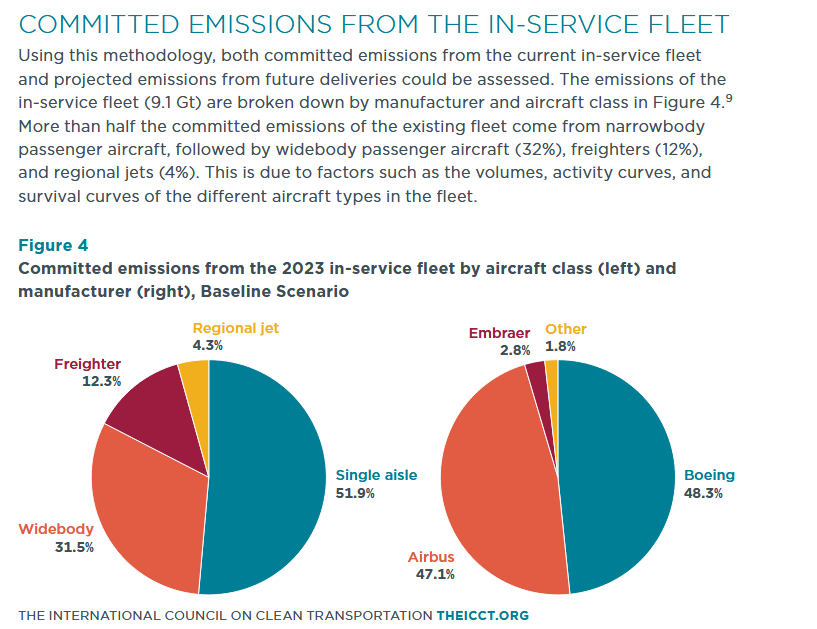

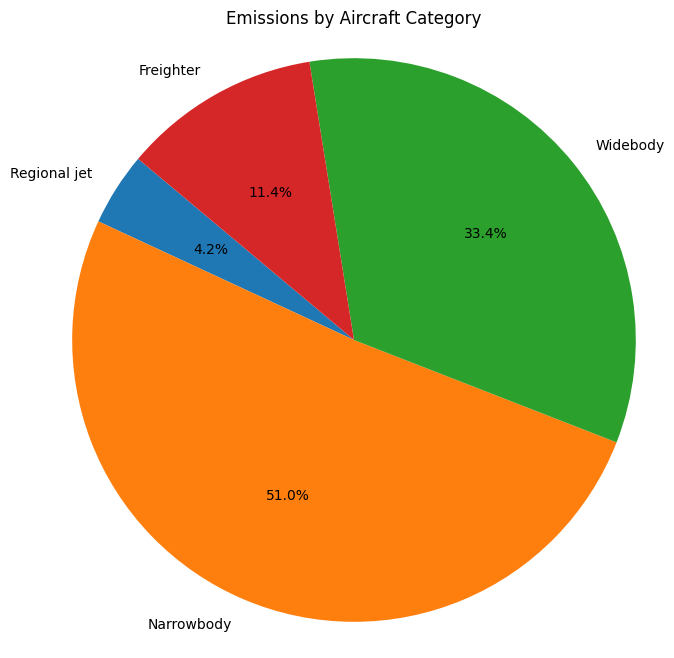

In [69]:
import matplotlib.pyplot as plt

# Assuming type_emission_existing is a dictionary
sizes = type_emission_existing.values()

translate_dict = {
    'Embraer 175': "Regional jet",
    'Boeing 737-800': "Narrowbody",
    'Boeing 787-9': "Widebody",
    'Boeing 777 Freighter': "Freighter",
    'Airbus A320':  "Narrowbody",
    'Airbus A330-200': "Widebody",  # only one entry kept
    'Airbus A330-200 Freighter': "Freighter"
}

# Aggregate values by translated category
values = {}
for key, emission in type_emission_existing.items():
    category = translate_dict.get(key, "Other")
    values[category] = values.get(category, 0) + emission

# Extract final labels and sizes
labels = list(values.keys())
sizes = list(values.values())

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Show percentage with 1 decimal place
    startangle=140      # Rotate the start of the pie chart for better layout
)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Emissions by Aircraft Category")
plt.show()


## Model benchmarking: Airbus 2022 deliveries
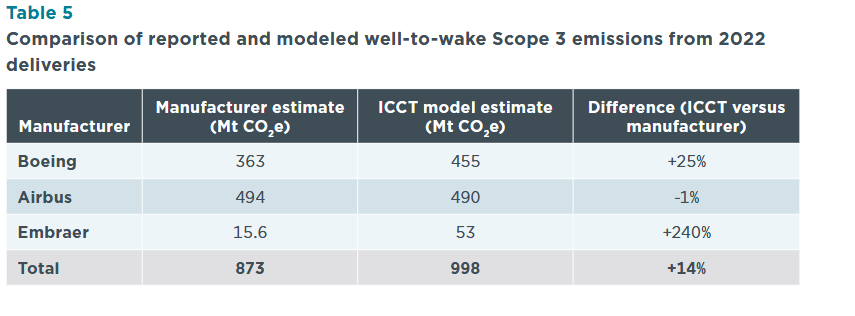

In [78]:

# =============================================================================
# Example 4: Airbus 2022 Deliveries Cross-Check for Scope 3 Disclosure
# =============================================================================

# According to the disclosure:
#   Total deliveries in 2022: 661 aircraft
#   Breakdown:
#     - A220 Family: 53 aircraft
#     - A320 Family: 516 aircraft
#     - A330 Family: 32 aircraft
#     - A350 Family: 60 aircraft

# For each type, we assume representative performance parameters:
# (Assumed values; adjust as needed based on actual performance data)
#
# A220 Family (smaller narrowbody; assume slightly lower speed and fuel burn)
#   - Mission speed: 550 km/h, Fuel burn: 3.00 kg/km
#
# A320 Family (using values similar to the A320neo example)
#   - Mission speed: 616 km/h, Fuel burn: 3.29 kg/km
#
# A330 Family (using values similar to the A330-900neo)
#   - Mission speed: 641 km/h, Fuel burn: 6.65 kg/km
#
# A350 Family (modern widebody; assumed values based on efficiency improvements)
#   - Mission speed: 665 km/h, Fuel burn: 5.80 kg/km

airbus_deliveries = [
    Aircraft('Airbus A220 Family', aircraft_type="Narrowbody", mission_speed=550, fuel_burn=3.00, count=53),
    Aircraft('Airbus A320 Family', aircraft_type="Widebody",  mission_speed=616, fuel_burn=3.29, count=516),
    Aircraft('Airbus A330 Family', aircraft_type="Widebody",  mission_speed=641, fuel_burn=6.65, count=32),
    Aircraft('Airbus A350 Family', aircraft_type="Widebody",  mission_speed=665, fuel_burn=5.80, count=60)
]

print("\nAirbus 2022 Deliveries Lifetime Emissions (Baseline Scenario):")
total_airbus_emissions = 0.0
for ac in airbus_deliveries:
    le = lifetime_emissions(
        ac,
        fuel_specific_energy=FUEL_SPECIFIC_ENERGY,
        fuel_ci_function=effective_fuel_ci_baseline,  # use baseline scenario
        start_year=year_of_delivery,
        lifespan=40
    )
    total_airbus_emissions += le
print(f"Total Airbus 2022 Deliveries Emissions: {total_airbus_emissions/1e9:.2f} Mt CO₂ vs 490 Mt CO₂")


Airbus 2022 Deliveries Lifetime Emissions (Baseline Scenario):
Total Airbus 2022 Deliveries Emissions: 471.84 Mt CO₂ vs 490 Mt CO₂


# Looking forward - New deliveries

## Single Boeing 737-MAX delivery in 2030

In [ ]:
# Demonstrate the impact for a new delivery in 2030:
year_of_delivery = 2030

# Use one representative new delivery aircraft
aircraft_example = Aircraft('Boeing 737-MAX', aircraft_type="Narrowbody", mission_speed=615, fuel_burn=3.36, count=1)

life_emissions_baseline = lifetime_emissions(
        aircraft_example,
        fuel_specific_energy=FUEL_SPECIFIC_ENERGY,
        fuel_ci_function=effective_fuel_ci_baseline,  # use baseline scenario
        start_year=year_of_delivery,
        lifespan=40
    )

life_emissions_optimistic = lifetime_emissions(
        aircraft_example,
        fuel_specific_energy=FUEL_SPECIFIC_ENERGY,
        fuel_ci_function=effective_fuel_ci_optimistic,  # use baseline scenario
        start_year=year_of_delivery,
        lifespan=40
    )

print("Example for a single Boeing 737-MAX delivered in 2030:")
print(f"  Baseline Lifetime Emissions: {life_emissions_baseline / 1e9:.2f} Megatonnes CO₂")
print(f"  Optimistic Lifetime Emissions: {life_emissions_optimistic / 1e9:.2f} Megatonnes CO₂")


## Airbus 2024 Market Forecast 

https://www.airbus.com/en/products-services/commercial-aircraft/global-market-forecast

More demand for aircraft replacement

People want to travel, and over the next 20 years, Airbus forecasts traffic will more than double (x2.4). In the first three years, Airbus expects traffic to grow at ~8% per year, to catch up lost growth over the pandemic, before reconnecting with an annual growth of approximately 3.6% from 2027 onwards.  

New aircraft deliveries (Passenger aircraft over 100 seats and Freighters over 10 tons’ payload) will increasingly replace older, less fuel efficient aircraft. Over the next 20 years we forecast a demand for more than 42,000 new deliveries. These aircraft will further reduce fuel burn per revenue passenger kilometre (RPK) which has already halved since 1990. 

Today, around 30% of the world’s in service aircraft fleet are of the latest generation. Replacing the remaining 70% of previous generation aircraft, combined with more efficient ways to operate aircraft, SAF, future technologies such as hydrogen and hybridisation are key to Airbus’ decarbonisation journey, along with the use of carbon capture technologies.


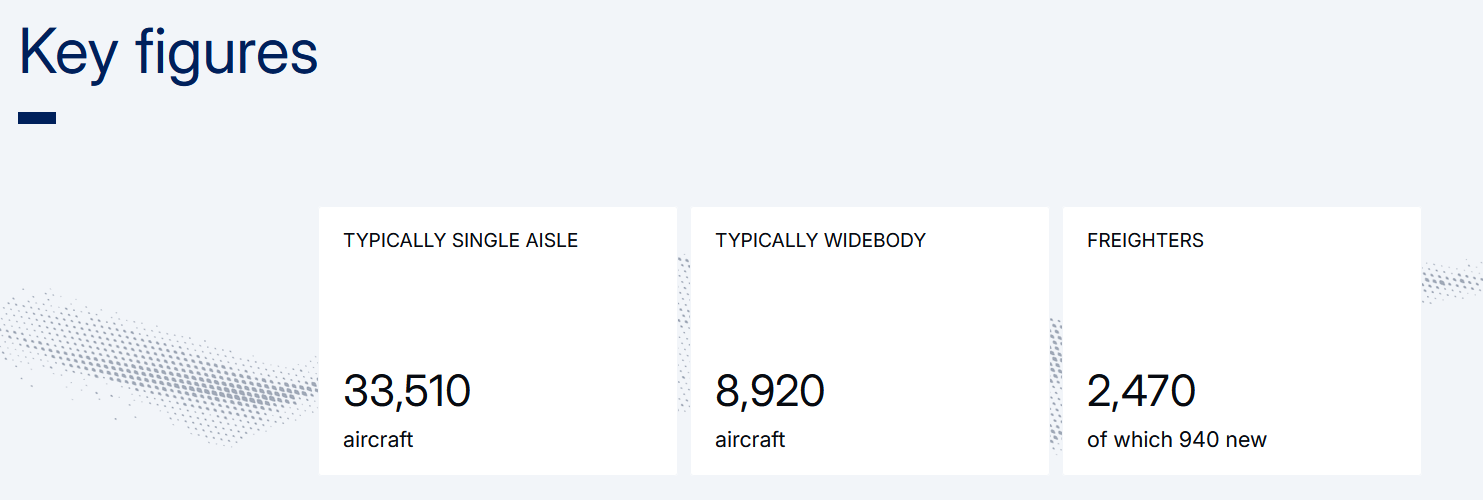

https://www.airbus.com/sites/g/files/jlcbta136/files/2024-07/GMF-2024-2043-Airbus-Commercial-Aircraft_3H6D.xlsx

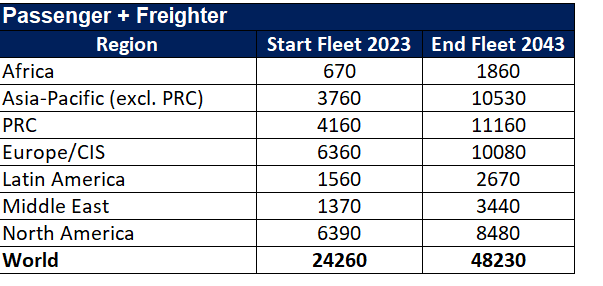

In [ ]:

# =============================================================================
# Example 2: Calculating Emissions for New Deliveries
# =============================================================================

# Representative aircraft types for new deliveries from 2024-2033 (based on Table 3)
# Here the delivery count numbers are hypothetical; actual counts would be taken from manufacturer forecasts.
new_deliveries = [
    Aircraft('Embraer 190 E2', mission_speed=513, fuel_burn=3.17, count=1000),
    Aircraft('Boeing 737-MAX', mission_speed=615, fuel_burn=3.36, count=2000),
    Aircraft('Airbus A320neo', mission_speed=616, fuel_burn=3.29, count=2000),
    Aircraft('Boeing 787', mission_speed=665, fuel_burn=6.17, count=1500),
    Aircraft('Airbus A330-900neo', mission_speed=641, fuel_burn=6.65, count=800),
    Aircraft('Airbus A330-300 Freighter', mission_speed=739, fuel_burn=7.52, count=300),
    Aircraft('Boeing 777 Freighter', mission_speed=724, fuel_burn=10.7, count=200)
]

print("Lifetime Emissions for New Deliveries (Baseline Scenario):")


### Modify this to reflect typical delivery rates ###
assert(1==0)

total_emissions_new= 0.0
type_emission_new = {}
for ac in new_deliveries:
    le = lifetime_emissions(
        ac,
        fuel_specific_energy=FUEL_SPECIFIC_ENERGY,
        fuel_ci_function=effective_fuel_ci_baseline,  # use baseline scenario
        start_year=2023,
        lifespan=50
    )
    print(f"  {ac.name}: {le / 1e12:.2f} Gt CO₂")
    total_emissions_existing += le
    type_emission_existing[ac.name] = le

